In [1]:
import urllib.request
import urllib.request
import json
import pandas as pd
import json

client_id = "NjCkeE5n21b4IPWLlbAi"
client_secret = "J6RWn6YJz8"

# ✨ 필요한 입력값
start_date = "2024-06-23"
end_date = "2025-06-23"
keywords = ["상지건설"]

# 🔧 요청 body 구성
body = {
    "startDate": start_date,
    "endDate": end_date,
    "timeUnit": "date",
    "keywordGroups": [
        {
            "groupName": keywords[0],
            "keywords": keywords
        }
    ],
    "device": "pc"
}

# 🔗 API 요청
url = "https://openapi.naver.com/v1/datalab/search"
request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id", client_id)
request.add_header("X-Naver-Client-Secret", client_secret)
request.add_header("Content-Type", "application/json")

response = urllib.request.urlopen(request, data=json.dumps(body).encode("utf-8"))
rescode = response.getcode()

# 📦 결과 확인
if rescode == 200:
    response_body = response.read()
else:
    print("Error Code:" + str(rescode))

# 네이버 API 응답 결과를 문자열로 받은 경우 (예: response_body.decode('utf-8'))
response_text = response_body.decode('utf-8')  # 너가 올린 JSON 문자열을 여기에 붙여넣거나 response_body.decode('utf-8') 대입

# JSON 문자열을 파이썬 객체로 변환
data_json = json.loads(response_text)

# 관심 데이터 추출
data_list = data_json['results'][0]['data']  # 첫 번째 키워드 그룹의 데이터

# DataFrame 생성
df = pd.DataFrame(data_list)

# 'period'를 datetime 형식으로 변환하고 인덱스로 지정
df['날짜'] = pd.to_datetime(df['period'])
df.drop(columns='period', inplace=True)
df.set_index('날짜', inplace=True)

df.head(3)

,ratio
날짜,
2024-06-23,0.02636
2024-06-24,0.10254
2024-06-25,0.15821


In [2]:
import pandas as pd

# 파일 경로 지정
file_path = 'daily_sentiment_summary.csv'

# CSV 파일을 DataFrame으로 불러오기
df1 = pd.read_csv(file_path)

# 불러온 데이터 확인 (선택)
print(df1.head())

           날짜  평균감성점수  게시글수  평균신뢰도                            감성분포
0  2025.06.08  -0.501     1  0.501                       {'부정': 1}
1  2025.06.09   0.273   216  0.501  {'긍정': 166, '부정': 49, '중립': 1}
2  2025.06.10   0.280   211  0.504           {'긍정': 164, '부정': 47}
3  2025.06.11   0.231   140  0.497  {'긍정': 101, '부정': 37, '중립': 2}
4  2025.06.12   0.258   340  0.498  {'긍정': 255, '부정': 81, '중립': 4}


In [3]:
df_reset = df.reset_index()

# 2. 날짜 컬럼 형식 통일 (datetime)
df_reset['날짜'] = pd.to_datetime(df_reset['날짜'])
df1['날짜'] = pd.to_datetime(df1['날짜'])

# 3. 날짜 기준으로 병합 (inner join)
df2 = pd.merge(df1, df_reset, on='날짜', how='inner')

df2.tail(3)

,날짜,평균감성점수,게시글수,평균신뢰도,감성분포,ratio
13,2025-06-21,0.202,10,0.503,"{'긍정': 7, '부정': 3}",0.30178
14,2025-06-22,0.315,16,0.505,"{'긍정': 13, '부정': 3}",0.23732
15,2025-06-23,0.225,83,0.504,"{'긍정': 60, '부정': 23}",2.29416


In [10]:
df2['weighted_score'] = df2['ratio'] * df2['평균감성점수']
df2.head(10)

,날짜,평균감성점수,게시글수,평균신뢰도,감성분포,ratio,weighted_score
0,2025-06-08,-0.501,1,0.501,{'부정': 1},0.47758,-0.239268
1,2025-06-09,0.273,216,0.501,"{'긍정': 166, '부정': 49, '중립': 1}",5.14210,1.403793
2,2025-06-10,0.280,211,0.504,"{'긍정': 164, '부정': 47}",3.77966,1.058305
3,2025-06-11,0.231,140,0.497,"{'긍정': 101, '부정': 37, '중립': 2}",3.63023,0.838583
4,2025-06-12,0.258,340,0.498,"{'긍정': 255, '부정': 81, '중립': 4}",13.28157,3.426645
5,2025-06-13,0.266,281,0.499,"{'긍정': 213, '부정': 65, '중립': 3}",9.17960,2.441774
6,2025-06-14,0.378,16,0.504,"{'긍정': 14, '부정': 2}",0.49809,0.188278
7,2025-06-15,0.316,16,0.504,"{'긍정': 13, '부정': 3}",0.33694,0.106473
8,2025-06-16,0.330,136,0.500,"{'긍정': 112, '부정': 23, '중립': 1}",4.94579,1.632111
9,2025-06-17,0.235,99,0.499,"{'긍정': 72, '부정': 26, '중립': 1}",3.31673,0.779432


In [5]:
from pykrx import stock
import pandas as pd
from datetime import datetime

def get_daily_returns(ticker, start_date="2022-01-01", end_date=None, save_csv=True):
    """
    한국 주식 티커의 일일 수익률을 계산하여 DataFrame 및 CSV로 저장합니다.
    Parameters:
    - ticker: str, 예: "005930" (삼성전자)
    - start_date: str, "YYYY-MM-DD"
    - end_date: str, "YYYY-MM-DD" (기본: 오늘)
    - save_csv: bool, True면 CSV로 저장
    Returns:
    - DataFrame: 날짜별 수익률 포함
    """
    if end_date is None:
        end_date = datetime.today().strftime("%Y-%m-%d")
    # 1. 일별 OHLCV 데이터 가져오기
    df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)
    # 2. 2일 뒤 종가 대비 수익률 계산
    df['Return'] = df['종가'].shift(1) / df['종가'] - 1
    # 3. 날짜 인덱스 리셋
    df.reset_index(inplace=True)
    # 4. 필요한 컬럼만 정리
    df = df[['날짜', '종가', 'Return']]
    # 5. 저장
    if save_csv:
        filename = f"{ticker}_2days_later_return.csv"
        df.to_csv(filename, index=False)
        print(f"[✓] Saved to {filename}")
    return df

df3 = get_daily_returns("042940", start_date="2024-06-21")
print(df3.tail(3))

[✓] Saved to 042940_2days_later_return.csv
            날짜     종가    Return
240 2025-06-20  13810  0.060101
241 2025-06-23  13250  0.042264
242 2025-06-24  13720 -0.034257


In [13]:
# 3. 날짜 기준으로 병합 (inner join)
df4 = pd.merge(df2, df3, on='날짜', how='inner')

df4.tail(3)

,날짜,평균감성점수,게시글수,평균신뢰도,감성분포,ratio,weighted_score,종가,Return
8,2025-06-19,0.237,98,0.494,"{'긍정': 71, '부정': 25, '중립': 2}",2.42894,0.575659,14640,0.060109
9,2025-06-20,0.292,88,0.498,"{'긍정': 69, '부정': 18, '중립': 1}",2.65748,0.775984,13810,0.060101
10,2025-06-23,0.225,83,0.504,"{'긍정': 60, '부정': 23}",2.29416,0.516186,13250,0.042264


📊 'Return'과 'weighted_score' 간의 상관계수: -0.8801


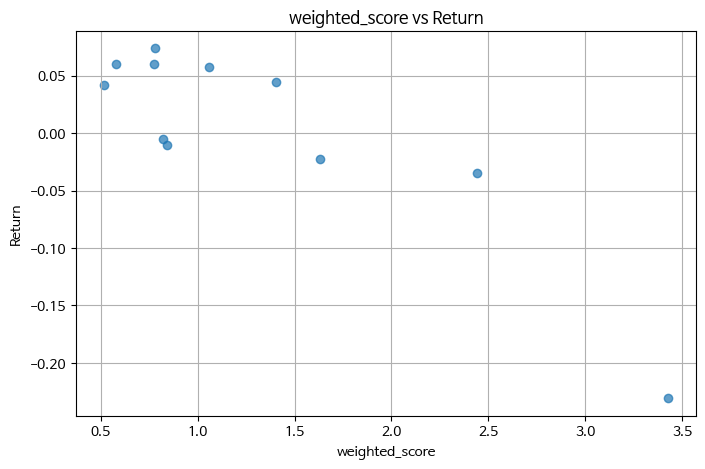

In [8]:
import matplotlib.pyplot as plt
clean_df = df4.dropna(subset=['Return', 'weighted_score'])

# 상관계수 계산
correlation = clean_df['Return'].corr(clean_df['weighted_score'])

print(f"📊 'Return'과 'weighted_score' 간의 상관계수: {correlation:.4f}")

plt.figure(figsize=(8, 5))
plt.scatter(clean_df['weighted_score'], clean_df['Return'], alpha=0.7)
plt.title("weighted_score vs Return")
plt.xlabel("weighted_score")
plt.ylabel("Return")
plt.grid(True)
plt.show()

📊 시차별 상관계수:
    Lag  Correlation
0    0    -0.880114
1    1    -0.068434
2    2     0.035270
3    3     0.196106
4    4    -0.148969
5    5     0.462450
6    6     0.253625
7    7    -0.118357

🎯 가장 높은 상관: lag 0.0일, 상관계수 = -0.8801


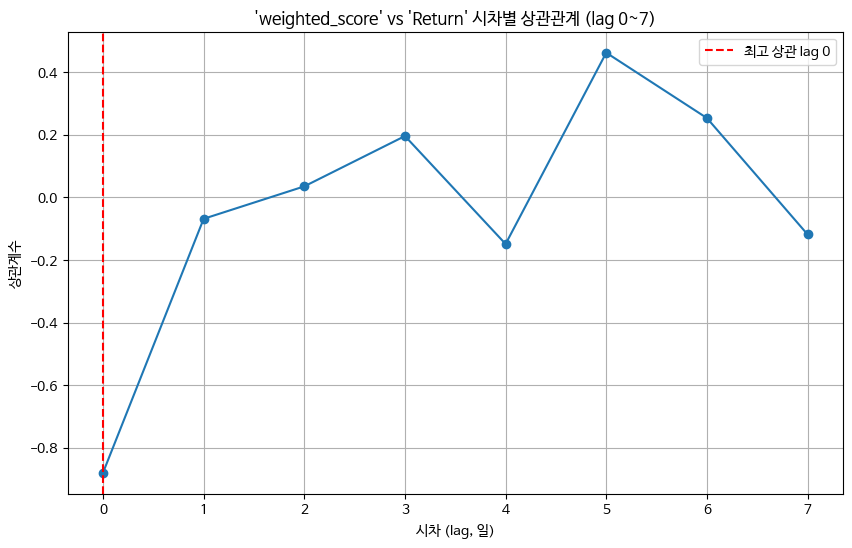

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def lagged_correlation_weighted_score(df, return_col='Return', score_col='weighted_score', max_lag=7):
    df = df.copy()
    results = []

    for lag in range(0, max_lag + 1):
        df[f'{return_col}_lag{lag}'] = df[return_col].shift(-lag)
        temp_df = df.dropna(subset=[f'{return_col}_lag{lag}', score_col])
        corr = temp_df[score_col].corr(temp_df[f'{return_col}_lag{lag}'])
        results.append({'Lag': lag, 'Correlation': corr})

    # 결과를 DataFrame으로 변환
    lag_df = pd.DataFrame(results)

    # 최고 상관관계 찾기
    best_row = lag_df.loc[lag_df['Correlation'].abs().idxmax()]

    # 결과 출력
    print("📊 시차별 상관계수:\n", lag_df)
    print(f"\n🎯 가장 높은 상관: lag {best_row['Lag']}일, 상관계수 = {best_row['Correlation']:.4f}")

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(lag_df['Lag'], lag_df['Correlation'], marker='o', linestyle='-')
    plt.axvline(best_row['Lag'], color='red', linestyle='--', label=f"최고 상관 lag {int(best_row['Lag'])}")
    plt.title(f"'weighted_score' vs '{return_col}' 시차별 상관관계 (lag 0~{max_lag})")
    plt.xlabel("시차 (lag, 일)")
    plt.ylabel("상관계수")
    plt.legend()
    plt.grid(True)
    plt.show()

    return lag_df, best_row

# 사용 예시 (df4를 기준으로)
lag_df, best_lag = lagged_correlation_weighted_score(df4, return_col='Return', score_col='weighted_score', max_lag=7)

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def build_regression_with_interval(df, return_col='Return', score_col='weighted_score', lag=3):
    df = df.copy()

    # lag일 뒤 수익률 타겟 생성
    df[f'{return_col}_target'] = df[return_col].shift(-lag)

    # 결측 제거
    data = df.dropna(subset=[score_col, f'{return_col}_target'])
    X = data[[score_col]]
    y = data[f'{return_col}_target']

    # train/test 분리 (shuffle=False 시계열 유지)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # 모델 학습 (랜덤포레스트 회귀)
    model = RandomForestRegressor(random_state=42, n_estimators=100)
    model.fit(X_train, y_train)

    # 테스트 예측 및 성능 확인
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print(f"테스트 MSE: {mse:.6f}")

    # 오차(잔차) 계산
    residuals = y_test - y_pred
    resid_std = np.std(residuals)

    return model, resid_std, lag

def predict_return_range(model, resid_std, weighted_score_value, lag, conf=1.96):
    """
    conf: 신뢰구간 z-score (1.96 = 약 95% 신뢰구간)
    """
    pred = model.predict([[weighted_score_value]])[0]
    lower = pred - conf * resid_std
    upper = pred + conf * resid_std

    print(f"{lag}일 후 예상 수익률: {pred:.4%}")
    print(f"예상 신뢰구간 (약 95%): {lower:.4%} ~ {upper:.4%}")
    return pred, lower, upper

In [36]:
model, resid_std, lag_used = build_regression_with_interval(df4, return_col='Return', score_col='weighted_score', lag=5)

# 예측
pred, low, high = predict_return_range(model, resid_std, weighted_score_value=0.5, lag=lag_used)

테스트 MSE: 0.000982
5일 후 예상 수익률: 1.6139%
예상 신뢰구간 (약 95%): -0.5729% ~ 3.8006%


c:\anaconda\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
